In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd

In [19]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [21]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [22]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [23]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [24]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [25]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

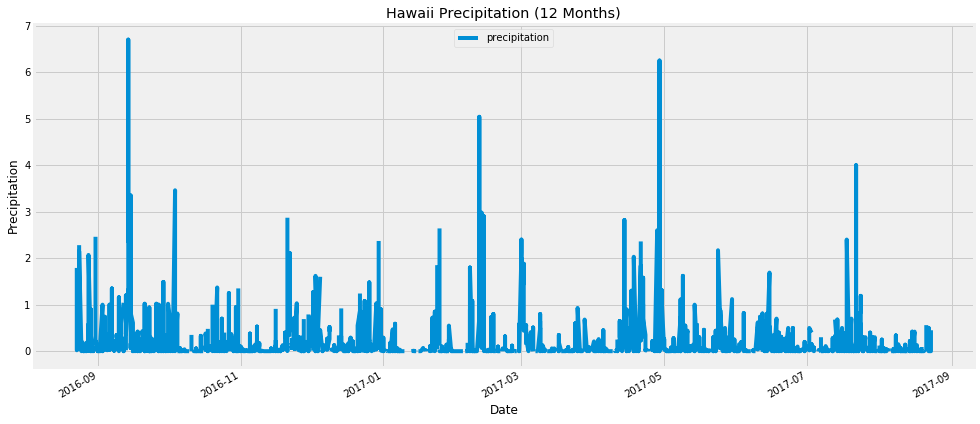

In [64]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last12m = session.query(Measurement.date).order_by(Measurement.date.desc()).first() # returns a tuple
date_last12m = last12m[0] # first value of tuple, returns 2017-08-23

# Calculate the date 1 year ago from the last data point in the database
date_1Ypast = dt.datetime.strptime(date_last12m, "%Y-%m-%d") - dt.timedelta(days=366) # returns 2016-08-22 00:00:00

# Perform a query to retrieve the data and precipitation scores
precip_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= date_1Ypast).all()
  # returns a list of tuples (date, precipitation) beginning on 2016-08-23, 
    # ".all" was absolutely necessary or query never runs
    
# Save the query results as a Pandas DataFrame and set the index to the date column
Hawaii_precip_df = pd.DataFrame(precip_query, columns=['Date', 'Precipitation'])
  # some values for 'precipitation' are 'NaN', not sure if this will become a problem
Hawaii_precip_df['date'] = pd.to_datetime(Hawaii_precip_df['date'], format='%Y-%m-%d')
Hawaii_precip_df.set_index('date', inplace=True) # setting date to index
    
# Sort the dataframe by date
Hawaii_precip_df.sort_values(by=['date'], ascending=True)
  # These appeared to already be ordered by date when viewing data, but ran this to be sure.

# Use Pandas Plotting with Matplotlib to plot the data
Hawaii_precip_df.plot(title="Hawaii Precipitation (12 Months)", figsize=(15,7))
plt.legend(loc='upper center')
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.savefig('Analysis/Hawii_Precipitation.png')
plt.show()

In [65]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Hawaii_precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [69]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"Available Stations from Dataset: {station_count}")

Available Stations from Dataset: 9


In [84]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)
                                ).group_by(Measurement.station
                                          ).order_by(func.count(Measurement.station).desc()
                                                    ).all()
print("Station Activity: ")
# print(f'{station_activity}')
sa_df = pd.DataFrame(station_activity, columns=['Station', 'Activity'])
sa_df.set_index('Station', inplace=True)
sa_df

Station Activity: 


,Activity
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [94]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temps_data = session.query(func.max(Measurement.tobs), func.min(Measurement.tobs), func.avg(Measurement.tobs)
                          ).filter(Measurement.station == station_activity[0][0]
                                  ).all()

print(f"Most Active Station: {station_activity[0][0]}")
print("Temperature Records:")
print(f"     High: {temps_data[0][0]}")
print(f"     Low: {temps_data[0][1]}")
print(f"     Average: {temps_data[0][2]}")

Most Active Station: USC00519281
Temperature Records:
     High: 85.0
     Low: 54.0
     Average: 71.66378066378067


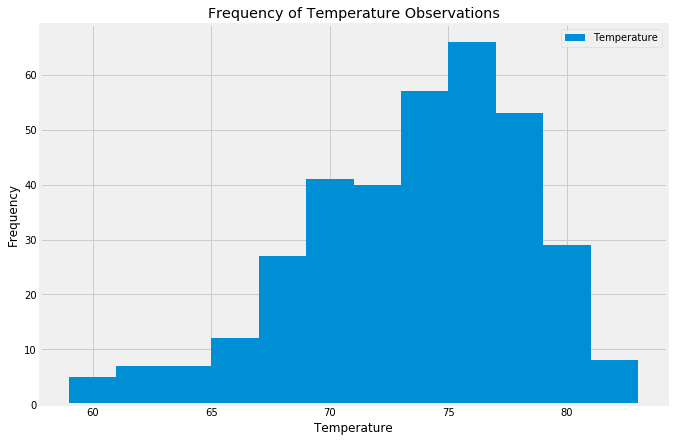

In [99]:
# Choose the station with the highest number of temperature observations.
    # station_activity[0][0] # returns USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs
                        ).filter(Measurement.date >= date_1Ypast
                                ).filter(Measurement.station == station_activity[0][0]
                                        ).all()
temp_obs_df = pd.DataFrame(temp_obs, columns=["Temperature"])
temp_obs_df.plot.hist(bins=12, title="Frequency of Temperature Observations", figsize=(10,7))
plt.legend(loc='upper right')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig('Analysis/Temperature_Observations.png')
plt.show()

In [100]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [106]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-05-20', '2017-05-31')
# trip
print(f"Trip Expected Max Temps:     {round((trip[0][2]), 2)}")
print(f"Trip Expected Min Temps:     {round((trip[0][0]), 2)}")
print(f"Trip Expected Average Temps: {round((trip[0][1]), 2)}")

Trip Expected Max Temps:     87.0
Trip Expected Min Temps:     69.0
Trip Expected Average Temps: 75.44


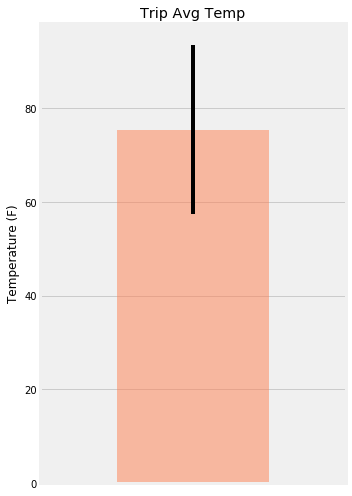

In [124]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_avg_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])
trip_avg_df.plot.bar(y='tavg', yerr=trip_avg_df['tmax']-trip_avg_df['tmin'], title="Trip Avg Temp", 
                 color='coral', alpha=.5, figsize=(5,7), legend=None)
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig('Analysis/Trip_Average_Temperature.png')
plt.show()

In [133]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
def calc_precip(start_date, end_date):
    """Precipitation and weather station information.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        List of tuples containing (station), (name), (latitude), (longitude), and (elevation), (precipitation amount).
    """
    
    cal_sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, 
               Measurement.prcp]
    
    return session.query(*cal_sel).\
        filter(Measurement.station == Station.station
              ).filter(Measurement.date >= start_date
                      ).filter(Measurement.date <= end_date
                              ).group_by(Measurement.station
                                        ).order_by(Measurement.prcp.desc()
                                                  ).all()

# function usage example
print(calc_precip('2017-05-20', '2017-05-31'))

[('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.02), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.01), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, None), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, None)]


In [134]:
# Just creating a DataFrame from the above information
rainfall = calc_precip('2017-05-20', '2017-05-31')
rainfall_df = pd.DataFrame(rainfall, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation', 'Precipitation'])
rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Precipitation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.02
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.01
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.00
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,NaN
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,NaN


## Optional Challenge Assignment

In [135]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [151]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
normals_start = '2017-05-20'
normals_end = '2017-05-31'

# Use the start and end date to create a range of dates
normals_dates = session.query(Measurement.date
                             ).filter(Measurement.date >= normals_start
                                     ).filter(Measurement.date <= normals_end
                                             ).group_by(Measurement.date).all()

ymd_norm_dates = [x[0] for x in normals_dates]

# Stip off the year and save a list of %m-%d strings
md_norm_dates = [y[5:] for y in ymd_norm_dates]

trip_norm_start = md_norm_dates[0]
trip_norm_end = md_norm_dates[-1]

# Loop through the list of %m-%d strings and calculate the normals for each date
norm_sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
trip_normals = session.query(*norm_sel
                             ).filter(func.strftime("%m-%d", Measurement.date) >= trip_norm_start
                                     ).filter(func.strftime("%m-%d", Measurement.date) <= trip_norm_end
                                             ).group_by(func.strftime("%m-%d", Measurement.date)
                                                       ).all()

trip_normals

[(68.0, 73.89655172413794, 79.0),
 (64.0, 72.96428571428571, 80.0),
 (64.0, 74.45614035087719, 80.0),
 (68.0, 74.94827586206897, 87.0),
 (67.0, 73.94827586206897, 79.0),
 (68.0, 74.27586206896552, 79.0),
 (65.0, 74.03636363636363, 82.0),
 (65.0, 74.49090909090908, 80.0),
 (67.0, 74.27777777777777, 82.0),
 (64.0, 74.19607843137256, 80.0),
 (69.0, 74.33333333333333, 81.0),
 (68.0, 74.4, 81.0)]

In [166]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_normals_df = pd.DataFrame(trip_normals, columns=['Trip Min', 'Trip Average', 'Trip Max'])
trip_normals_df['Date'] = pd.to_datetime(ymd_norm_dates, format= '%Y-%m-%d')
trip_normals_df.set_index('Date', inplace=True)
trip_normals_df

,Trip Min,Trip Average,Trip Max
Date,,,
2017-05-20,68.0,73.896552,79.0
2017-05-21,64.0,72.964286,80.0
2017-05-22,64.0,74.456140,80.0
2017-05-23,68.0,74.948276,87.0
2017-05-24,67.0,73.948276,79.0
2017-05-25,68.0,74.275862,79.0
2017-05-26,65.0,74.036364,82.0
2017-05-27,65.0,74.490909,80.0
2017-05-28,67.0,74.277778,82.0


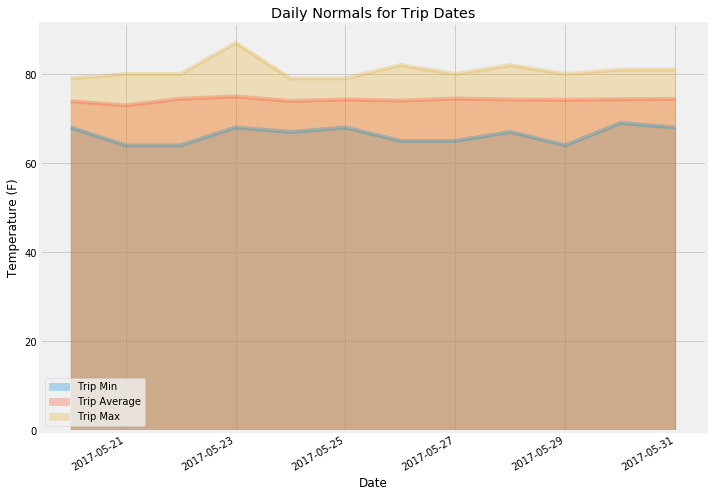

In [168]:
# Plot the daily normals as an area plot with `stacked=False`
trip_normals_df.plot(kind='area', stacked=False, alpha=.3, x_compat=True, title="Daily Normals for Trip Dates", figsize=(10,7))
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.tight_layout()
plt.savefig("Analysis/Trip_Daily_Normals.png")
plt.show()